<a href="https://colab.research.google.com/github/elenadigrigoli/FDS-project/blob/Emilio/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torch.cuda import is_available


In [3]:
!git clone https://github.com/elenadigrigoli/FDS-project.git

Cloning into 'FDS-project'...
remote: Enumerating objects: 43655, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 43655 (delta 59), reused 65 (delta 31), pack-reused 43538 (from 1)
Receiving objects: 100% (43655/43655), 1.22 GiB | 41.35 MiB/s, done.
Resolving deltas: 100% (172/172), done.
Updating files: 100% (21723/21723), done.


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Percorso del dataset
dataset_path = r'/content/FDS-project/data'

# Trasformazioni per preprocessing e data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Caricamento del dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

class_names = full_dataset.classes

# Divisione del dataset in train, validation e test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Creazione dei DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Controllo delle classi
print(f"Classi nel dataset: {full_dataset.classes}")


Classi nel dataset: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


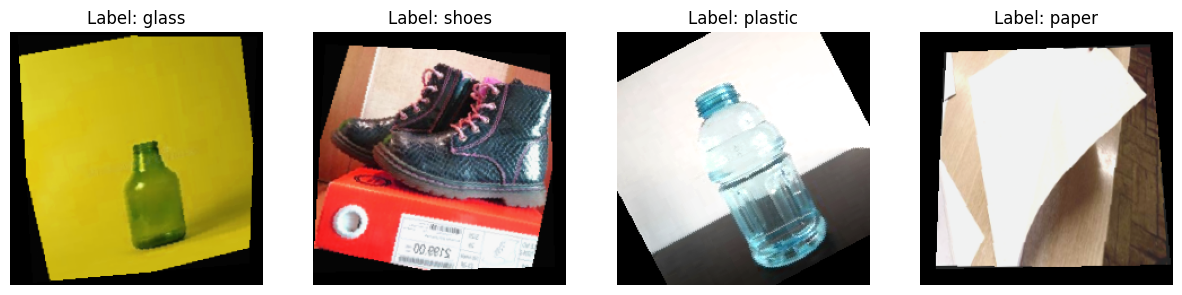

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Funzione per de-normalizzare le immagini
def denormalize_image(tensor, mean, std):
    tensor = tensor.clone()  # Crea una copia per evitare modifiche all'originale
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Operazione inversa della normalizzazione
    return tensor

# Funzione per visualizzare un batch di immagini
def show_images_from_loader(loader, full_dataset, mean, std):
    """
    Visualizza un batch di immagini preprocessate con le relative etichette.

    Args:
        loader (DataLoader): Il DataLoader da cui estrarre un batch.
        full_dataset (Dataset): Il dataset originale contenente le classi.
        mean (list): Media utilizzata per la normalizzazione.
        std (list): Deviazione standard utilizzata per la normalizzazione.
    """
    classes = full_dataset.classes  # Ottieni le classi dal dataset originale
    data_iter = iter(loader)
    images, labels = next(data_iter)  # Preleva un batch

    # De-normalizza il batch
    images = images.clone()
    for i in range(images.size(0)):
        images[i] = denormalize_image(images[i], mean, std)

    # Converti in formato numpy per matplotlib
    images = images.numpy().transpose((0, 2, 3, 1))  # Da CxHxW a HxWxC

    # Visualizza le prime 4 immagini del batch
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i >= len(images):  # Evita errori se ci sono meno di 4 immagini nel batch
            break
        ax.imshow(np.clip(images[i], 0, 1))  # Assicura che i valori siano nel range [0, 1]
        ax.axis("off")
        ax.set_title(f"Label: {classes[labels[i]]}")
    plt.show()

# Parametri per la normalizzazione (standard ImageNet)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Esegui la funzione per visualizzare un batch
show_images_from_loader(train_loader, full_dataset, mean, std)

In [6]:
import torch

# Configura il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [7]:
# Funzione per addestrare il modello
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%")

        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        print(f"Validation Acc: {val_accuracy:.2f}%")


In [8]:
from torchvision import models
import torch.nn as nn

# Numero di classi nel dataset
num_classes = len(train_loader.dataset.dataset.classes)  # Cambia se necessario

# Definizione dei modelli
models_dict = {
    "ResNet50": models.resnet50(pretrained=True),
    "VGG16": models.vgg16(pretrained=True),
    "DenseNet121": models.densenet121(pretrained=True),
    "MobileNetV2": models.mobilenet_v2(pretrained=True)
}

# Modifica l'ultimo layer di ciascun modello
for name, model in models_dict.items():
    if "fc" in model.__dict__:  # Modelli come ResNet
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif "classifier" in model.__dict__:  # Modelli come VGG e MobileNet
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.4MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [10]:
import torch.optim as optim

# Addestramento ResNet50
model = models_dict["ResNet50"]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nTraining ResNet50...")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Valutazione sul test set
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy for ResNet50: {test_accuracy:.2f}%")



Training ResNet50...
Epoch 1/10, Loss: 0.3552, Train Acc: 88.21%
Validation Acc: 86.69%
Epoch 2/10, Loss: 0.3125, Train Acc: 89.51%
Validation Acc: 87.59%
Epoch 3/10, Loss: 0.2975, Train Acc: 90.17%
Validation Acc: 89.20%
Epoch 4/10, Loss: 0.2663, Train Acc: 91.08%
Validation Acc: 88.48%
Epoch 5/10, Loss: 0.2561, Train Acc: 91.49%
Validation Acc: 88.42%
Epoch 6/10, Loss: 0.2382, Train Acc: 91.78%
Validation Acc: 87.26%
Epoch 7/10, Loss: 0.2307, Train Acc: 92.20%
Validation Acc: 87.84%
Epoch 8/10, Loss: 0.2110, Train Acc: 92.94%
Validation Acc: 88.37%
Epoch 9/10, Loss: 0.2019, Train Acc: 93.16%
Validation Acc: 87.59%
Epoch 10/10, Loss: 0.1966, Train Acc: 93.49%
Validation Acc: 89.84%
Test Accuracy for ResNet50: 89.69%


In [11]:
# Addestramento VGG16
model = models_dict["VGG16"]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nTraining VGG16...")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Valutazione sul test set
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy for VGG16: {test_accuracy:.2f}%")



Training VGG16...
Epoch 1/10, Loss: 2.1702, Train Acc: 30.78%
Validation Acc: 36.78%
Epoch 2/10, Loss: 1.7926, Train Acc: 38.21%
Validation Acc: 41.57%
Epoch 3/10, Loss: 1.6695, Train Acc: 42.28%
Validation Acc: 45.60%
Epoch 4/10, Loss: 1.6180, Train Acc: 44.67%
Validation Acc: 43.55%
Epoch 5/10, Loss: 1.5454, Train Acc: 46.79%
Validation Acc: 50.60%
Epoch 6/10, Loss: 1.5067, Train Acc: 48.31%
Validation Acc: 50.02%
Epoch 7/10, Loss: 1.5096, Train Acc: 48.63%
Validation Acc: 51.91%
Epoch 8/10, Loss: 1.4120, Train Acc: 51.24%
Validation Acc: 50.23%
Epoch 9/10, Loss: 1.4288, Train Acc: 51.32%
Validation Acc: 49.98%
Epoch 10/10, Loss: 1.4311, Train Acc: 51.08%
Validation Acc: 56.06%
Test Accuracy for VGG16: 56.51%


In [ ]:
# Addestramento DenseNet121
model = models_dict["DenseNet121"]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nTraining DenseNet121...")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Valutazione sul test set
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy for DenseNet121: {test_accuracy:.2f}%")



Training DenseNet121...
Epoch 1/10, Loss: 0.8650, Train Acc: 73.46%
Validation Acc: 81.94%
Epoch 2/10, Loss: 0.5197, Train Acc: 83.10%
Validation Acc: 85.38%
Epoch 3/10, Loss: 0.4383, Train Acc: 85.80%
Validation Acc: 82.34%
Epoch 4/10, Loss: 0.3971, Train Acc: 86.84%
Validation Acc: 83.99%
Epoch 5/10, Loss: 0.3540, Train Acc: 88.12%
Validation Acc: 88.07%
Epoch 6/10, Loss: 0.3296, Train Acc: 89.00%
Validation Acc: 88.30%
Epoch 7/10, Loss: 0.2984, Train Acc: 90.06%
Validation Acc: 88.67%
Epoch 8/10, Loss: 0.2818, Train Acc: 90.56%
Validation Acc: 89.54%
Epoch 9/10, Loss: 0.2620, Train Acc: 91.25%
Validation Acc: 89.45%


In [ ]:
# Addestramento MobileNetV2
model = models_dict["MobileNetV2"]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\nTraining MobileNetV2...")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# Valutazione sul test set
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy for MobileNetV2: {test_accuracy:.2f}%")


In [ ]:
import matplotlib.pyplot as plt

# Confronto dell'accuracy
model_names = list(results.keys())
accuracies = list(results.values())

# Grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title("Test Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()


In [ ]:
# Salva i modelli
for name, model in models_dict.items():
    torch.save(model.state_dict(), f"{name}_model.pth")
    print(f"Saved {name} model.")
